The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


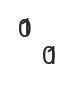

In [10]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

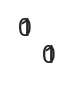

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


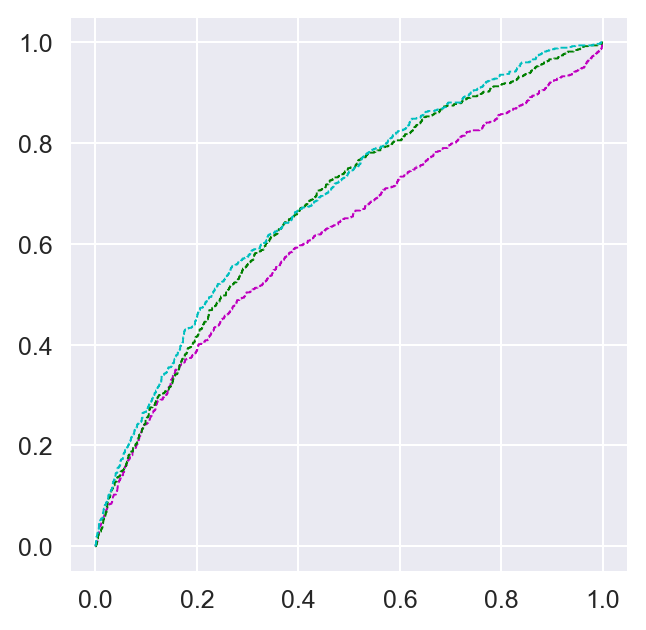

In [6]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

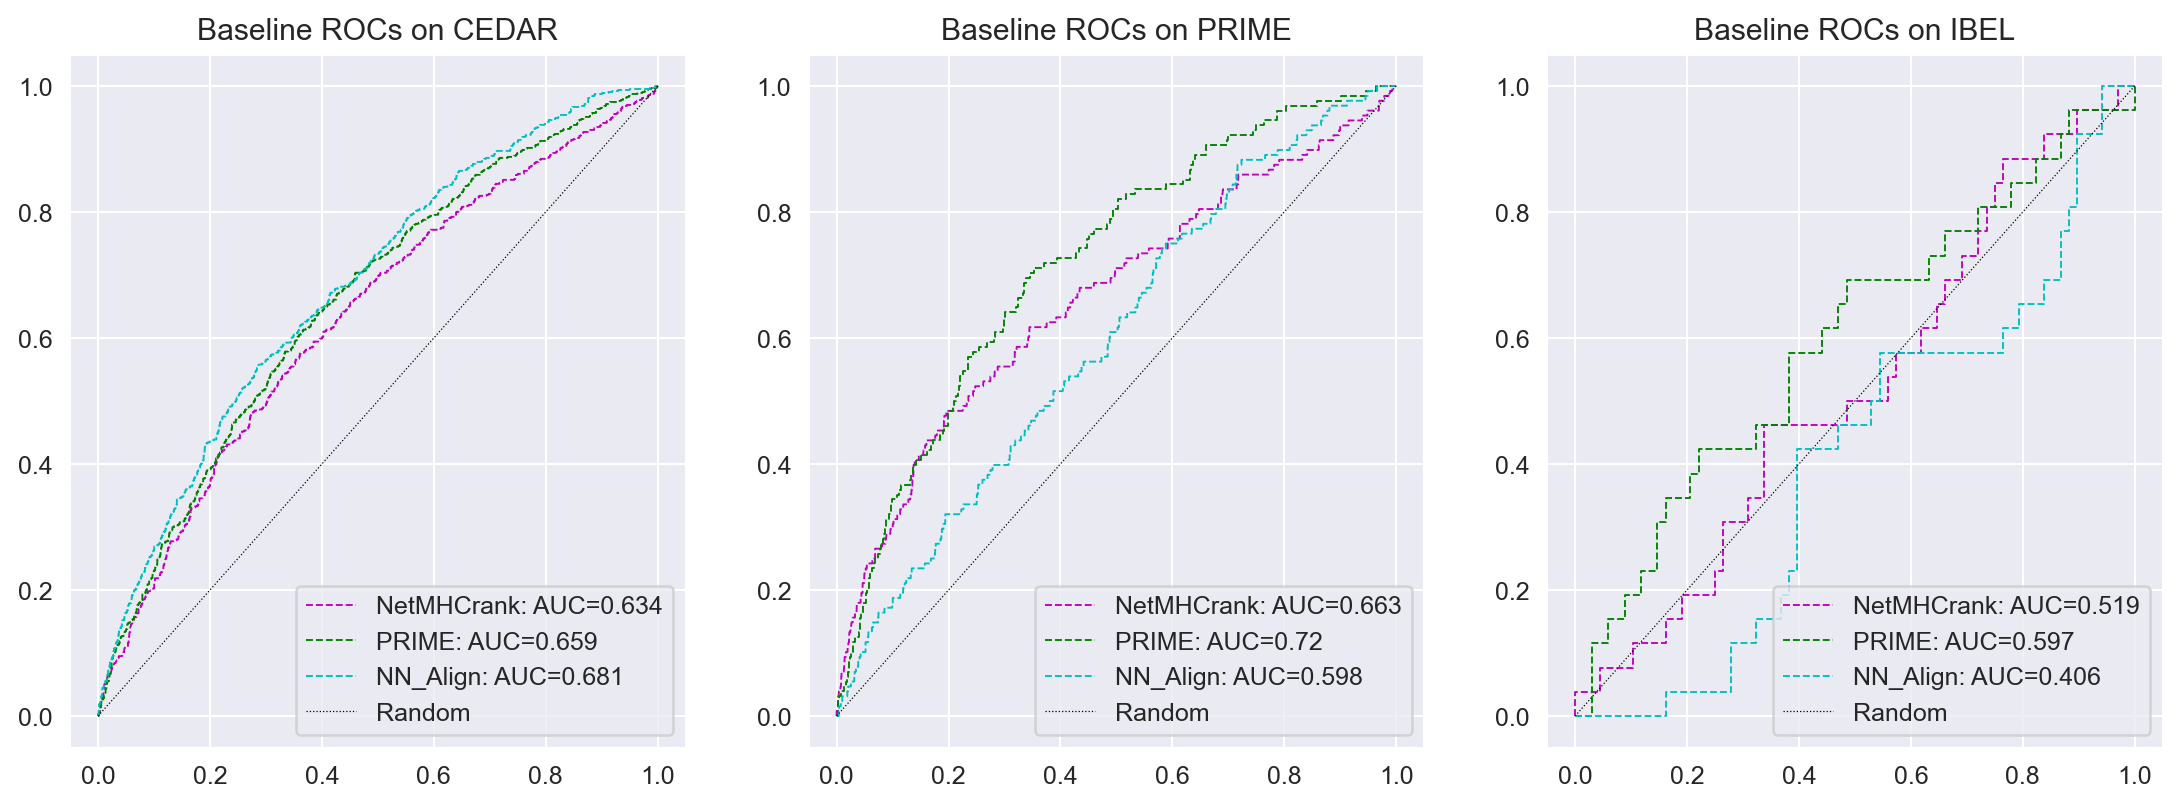

In [8]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

# Redo NNalign with custom partition

## Make folds for PRIME and IBEL

In [ ]:
# Since Ibel's dataset is very small, make random partition (5fold)
from sklearn.model_selection import StratifiedKFold 
kf = StratifiedKFold(5, shuffle=True, random_state=13)
ibel['fold'] = 0
for i, (_, test) in enumerate(kf.split(ibel['Peptide'], ibel['Target'])):
    ibel.iloc[test, ibel.columns.get_loc('fold')] = i

In [ ]:
ibel.to_csv('../data/mutant/221117_ibel_merged_fold.csv', index=False)

In [ ]:
# Make folds for PRIME using hobohm-1 (sim = 0.9)
prime_related['Peptide'].to_csv('../../kern_dist/data/221117_prime_related.pep', index=False, header=False)

In [ ]:
from src.partition_tools import pipeline_stratified_kfold
prime_related = pipeline_stratified_kfold('../../kern_dist/out/221117_prime_related.pep_0.9.out', prime_related.reset_index(drop=True), 
                          k=5, shuffle=True, seed = 13, pep_col='Peptide', elrank_col='EL_rank_mut')
prime_related.to_csv('../data/mutant/221117_prime_related_newcore_fold.csv', index=False)

## Saving with fold

In [ ]:
ibel[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_ibel_fold.pep' ,index=False, header=False, sep='\t')
prime_related[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_prime_related_fold.pep',
                                                       index=False, header=False, sep='\t')
cedar_related[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_cedar_fold.pep',
                                              index=False, header=False, sep='\t')


# NN expl:

either fully linear NN to use standard input

or CNN for seq + linear for additional features

Do standard NN first because it will be easier to just adapt (inshallah) a few fcts to handle the features as they currently are

## Check standardizer

In [ ]:
ffn = FFNetPipeline(n_in=21, n_hidden=10, n_layers=1, act=nn.ReLU())

In [ ]:
x_train = torch.rand(size = [10000, 21])
y_train = torch.randint(low=0, high=1, size=[10000,1])

x_test = torch.rand(size = [100, 21])
y_test = torch.randint(low=0, high=1, size=[100,1])
print(ffn.standardizer.sigma)
ffn.fit_standardizer(x_train)
print(ffn.standardizer.sigma)
ffn.reset_parameters()
print(ffn.standardizer.sigma)

## Check single train fct

In [12]:
x,y = get_dataset(cedar_related, None, max_len=12, encoding='onehot', blosum_matrix=None)
x,y = to_tensors(x,y,'cpu')
rand_pred = torch.rand(size=[len(y)])

In [13]:
rand_pred.shape, y.shape

(torch.Size([3033]), torch.Size([3033, 1]))

In [14]:
y.dtype, rand_pred.dtype

(torch.float32, torch.float32)

In [15]:
criterion = nn.BCELoss()
criterion(rand_pred, y.squeeze(1))

tensor(1.0184)

## Debug train wrapper/fct

In [16]:
from src.nn_train_eval import nested_kcv_train_nn
from src.models import FFNetPipeline

In [ ]:
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix':None,
                   'standardize':True,
                   'seq_col':'Peptide',
                   'hla_col':'HLA',
                   'target_col':'agg_label',
                   'rank_col':'EL_rank_mut',
                   'mut_col':['dissimilarity_score'],
                   'adaptive':False,
                   'mask':False,
                   'add_rank':True,
                   'add_aaprop':False,
                   'remove_pep':False}

In [ ]:

ics_dict = ics_kl
model = FFNetWrapper(n_in=22, n_hidden=30, dropout=0)
optimizer = optim.Adam(model.parameters(), lr = 5e-4)
criterion = nn.CrossEntropyLoss()
device = 'cpu'
n_jobs = 6
training_kwargs = {'n_epochs':300,
                   'early_stopping':True,
                   'patience': 10,
                   'delta': 1e-5,
                   'filename': 'checkpoint_test',
                   'verbosity':1}

models_dict, train_metrics, test_metrics = nested_kcv_train_nn(cedar_related, model, optimizer, criterion, device,
                                                               ics_dict, encoding_kwargs, training_kwargs, n_jobs)

FCTs now work ; Need to write entire tune-whatever script with all the conditions
Need to check training and hyperparams

# Check hyperparams

## nostop

In [104]:
dump = pkl_load('../output/nn_test/0.0001_0.01_NoStop/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

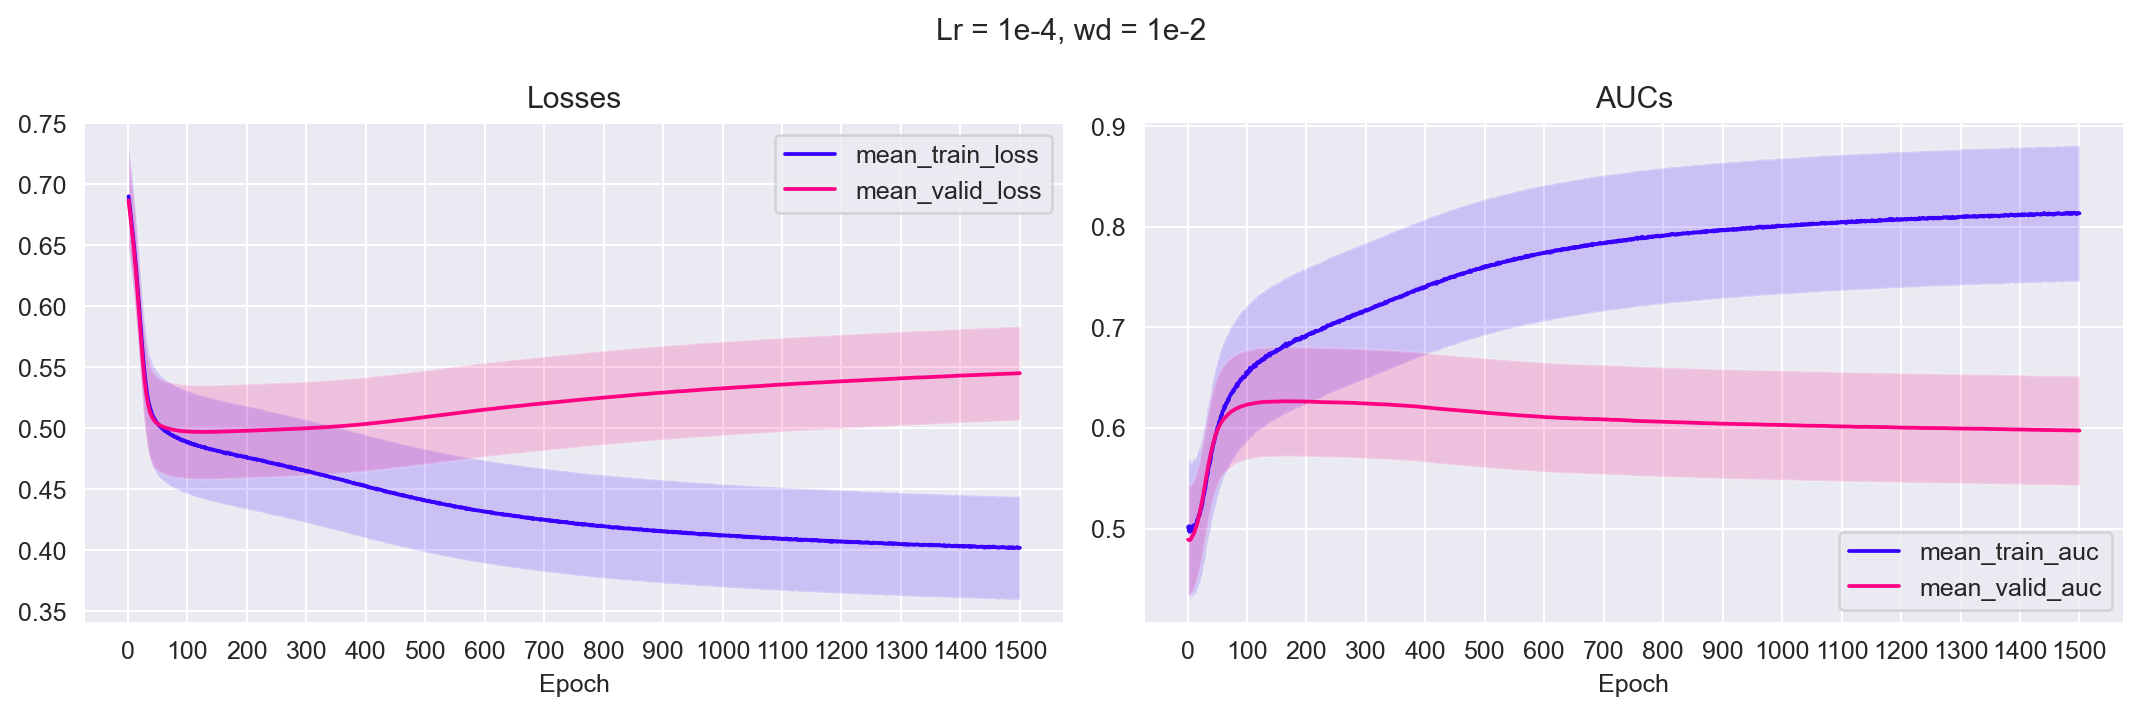

In [105]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1600, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1600, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')
f.suptitle('Lr = 1e-4, wd = 1e-2')
f.tight_layout()

In [108]:
dump = pkl_load('../output/nn_test/0.000333_0.001_NoStop/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

In [156]:
AA_KEYS.index('C')

4

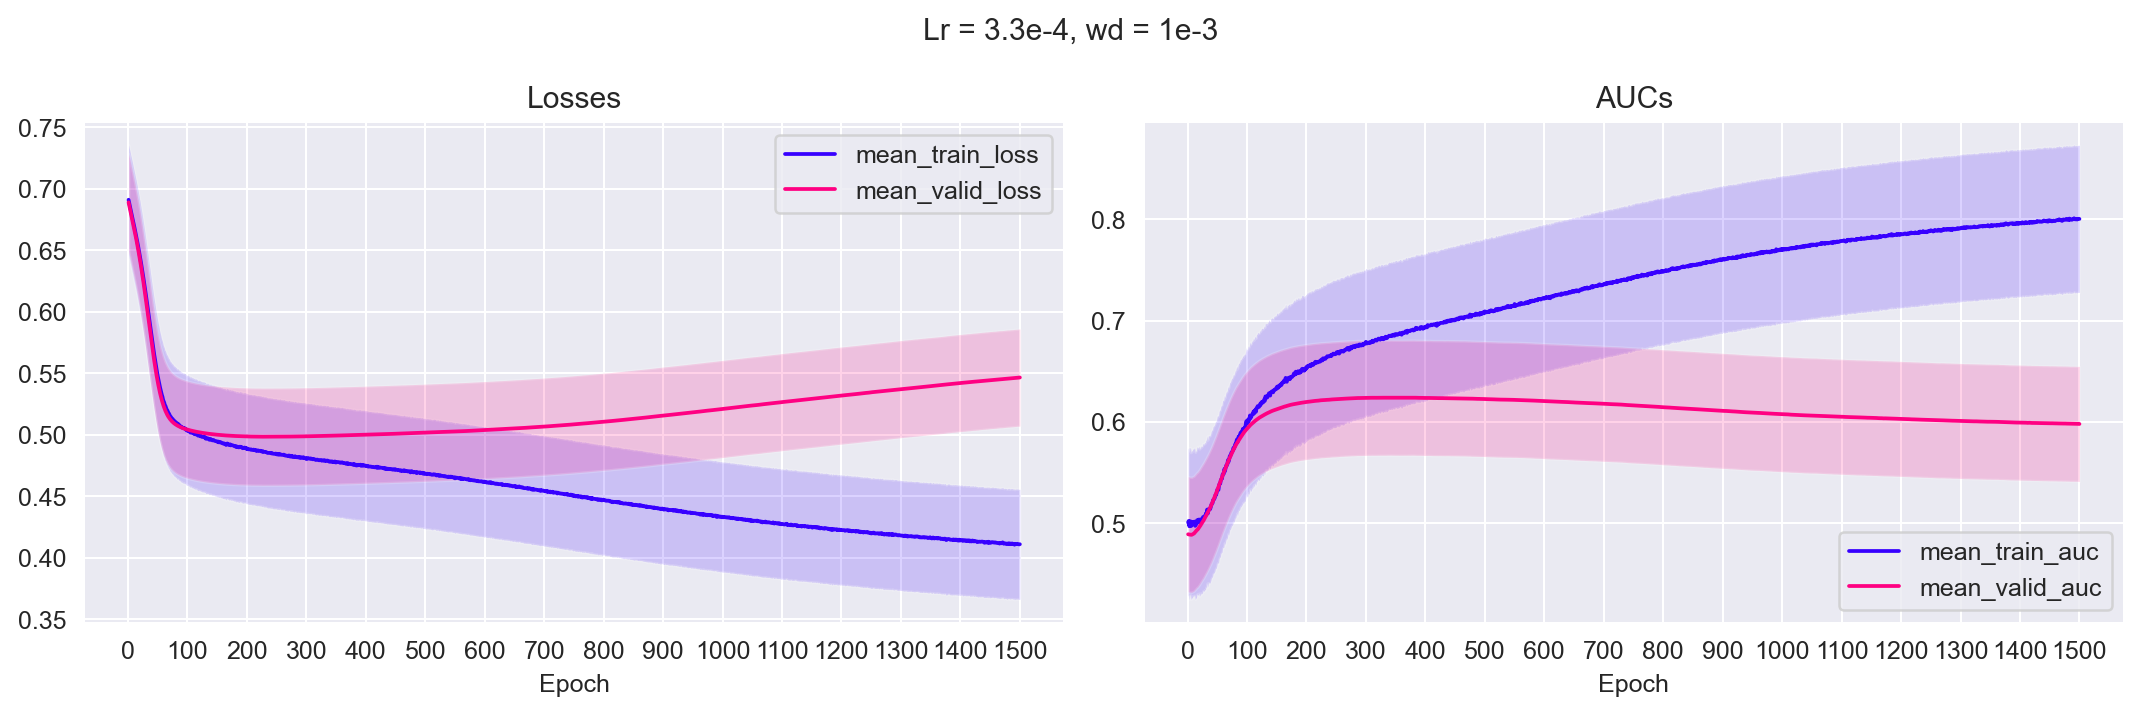

In [153]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1600, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1600, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')

f.suptitle('Lr = 3.3e-4, wd = 1e-3')
f.tight_layout()
f.savefig('test.png', bbox_inches='tight')

In [110]:
dump = pkl_load('../output/nn_test/5e-05_0.005_NoStop/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

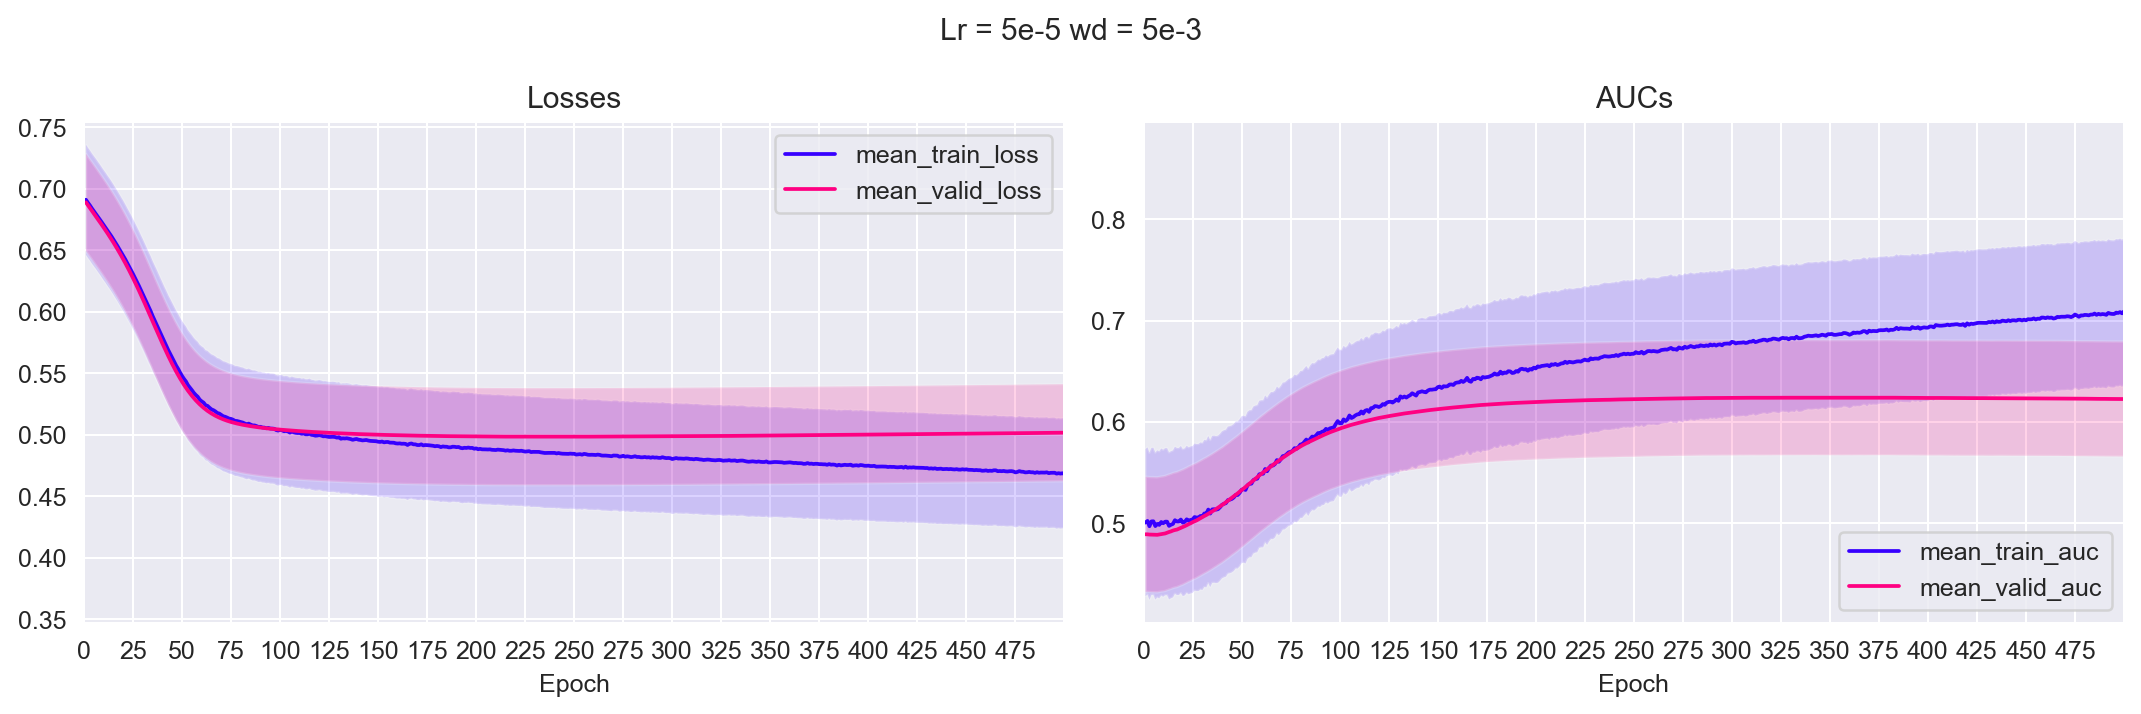

In [116]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1600, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1600, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')


xmax=500
a[0].set_xticks(np.arange(0, xmax, 25) )
a[1].set_xticks(np.arange(0, xmax, 25) )

a[0].set_xlim([0,xmax])
a[1].set_xlim([0,xmax])

f.suptitle('Lr = 5e-5 wd = 5e-3')
f.tight_layout()

In [143]:
ls=[0.6567465829184331, 0.6550815471140037, 0.6534638730178316, 0.6518615987671323, 0.6502401847763365, 0.6486053827749305, 0.64697095549914, 0.6453247051315004, 0.6436410539178734, 0.6419397267212431,
 0.6402062113541531, 0.6384131723191159, 0.6365623182034588, 0.6346474403879082, 0.6326924987523205, 0.6306836127759926, 0.6285466026974864, 0.6263084672836668, 0.6239295231393609, 0.6214420249262654,
 0.6188525032712169, 0.6161218883981743, 0.61325129047333, 0.6102106499956899, 0.606966232161123, 0.6035873108651059, 0.6001414915479987, 0.5965242058157446, 0.5928505756465562, 0.589112868347016, 0.5853500185734722,
 0.5814859518016952, 0.5776530304752973, 0.5738566247115572, 0.5700139562447233, 0.5662311151683093, 0.562670591817909, 0.5591227134385431, 0.5557173082078121, 0.5524378278815889, 0.5492826918681779, 0.5461824849782237, 
 0.543219352623381, 0.5404119712423043, 0.5377748050537717, 0.5353213871617716, 0.5330424857329562, 0.5309785706588471, 0.5290569710541532, 0.5273117168966043, 0.5257044460668981]
aucs=[0.5436451808446151, 0.5403111739745403,
 0.5361689230147504, 0.5309153364316024, 0.5237421701353808, 0.5186906445746615, 0.5157607597494442, 0.5148514851485149, 0.5074762578298646, 0.5033340068700747, 0.4971711456859972, 0.49020004041220455, 0.4777732875328349, 
 0.4633259244291776, 0.4512022630834512, 0.4409981814507981, 0.43705799151343705, 0.43534047282279253, 0.4348353202667205, 0.43534047282279253, 0.4316023439078602, 0.43129925237421696, 0.4296827641947868, 
 0.42806627601535663, 0.42857142857142855, 0.42776318448171347, 0.42786421499292787, 0.42776318448171347, 0.4271570014144272, 0.4266518488583552, 0.42766215397049906, 0.4282683370377854, 0.4282683370377854, 
 0.42988482521721555, 0.42978379470600114, 0.42948070317235804, 0.4303899777732875, 0.4311982218630026, 0.43089513032935944, 0.4321074964639321, 0.4330167710648616, 0.4340270761770055, 0.43473428975550615, 
 0.43665386946857954, 0.43776520509193784, 0.43978581531622546, 0.4399878763386543, 0.4410992119620125, 0.441200242473227, 0.4410992119620125, 0.44261466963022833]

lsgood = [0.7588277988963656, 0.7567359473970201, 0.7546450230810378, 0.7525477608044943, 0.7504405975341797, 0.748314360777537, 0.7461318506134881, 0.7439227104187012, 0.7416552702585856, 0.7393216292063395, 0.7369136479165819, 0.7344076765908135, 0.7318082451820374, 0.7291145722071329, 0.7262762983640035, 0.7233237557941012, 0.7202429175376892, 0.7170414196120368, 0.7136947843763564, 0.7101289431254069, 0.7063656250635783, 0.7024261951446533, 0.6983326342370775, 0.6941030621528625, 0.6897140542666117, 0.6851074364450243, 0.6803878413306342, 0.675465014245775, 0.6703692409727309, 0.6651210188865662, 0.6596987181239657, 0.6541105707486471, 0.6483676897154914, 0.6425298584832085, 0.6364577611287435, 0.6303984522819519, 0.6242359677950541, 0.618070642153422, 0.6117905643251207, 0.6055702765782675, 0.599456959300571, 0.5933014419343736, 0.587206158373091, 0.5813481211662292, 0.5756082269880507, 0.5701939662297567, 0.564940439330207, 0.5596788260671828, 0.5546553664737277, 0.549977097246382, 0.54559326171875, 0.5415144430266486, 0.5376759303940667, 0.5341628392537435, 0.530947314368354, 0.5280621316697862, 0.5254959861437479, 0.5230811768107944, 0.5209031171268887, 0.5190036230617099, 0.5172965990172492, 0.515767236550649, 0.5144167873594496, 0.5132517218589783, 0.5122399197684394, 0.5112798280186124, 0.5104647742377387, 0.5097359816233317, 0.5090478195084466, 0.5083798766136169, 0.507807453473409, 0.507254978020986, 0.5067124962806702, 0.506231062942081, 0.5058109164237976, 0.5054344601101346, 0.5050639046563042, 0.5046853290663825, 0.5043372511863708, 0.5039921535385979, 0.5036387907134162, 0.5033624238438077, 0.5030902557902865, 0.502794086933136, 0.5025159782833524, 0.5022733940018548, 0.5020302732785543, 0.5017804635895623, 0.5015312499470181, 0.5012938976287842, 0.5010832415686713, 0.50086467133628, 0.5006523264778985, 0.5004409684075249, 0.5002373589409722, 0.500033007727729, 0.4998280604680379, 0.4996562997500102, 0.4994881947835286, 0.4993284477127923, 0.4991796082920498, 0.49902458985646564, 0.49886417388916016, 0.4986914528740777, 0.4985251956515842, 0.49840231074227226, 0.49827847878138226, 0.4981418980492486, 0.49798355499903363, 0.49782894717322457, 0.4976971877945794, 0.4975955155160692, 0.4974789222081502, 0.49736841519673664, 0.4972523980670505, 0.4971323808034261, 0.49701705906126237, 0.4969033930036757, 0.49677791198094684, 0.4966736634572347, 0.49656443463431466, 0.49646952417161727, 0.4963572886255052, 0.49623635080125594, 0.49611829386817086, 0.4960029588805305, 0.4958925445874532, 0.49581334988276166, 0.49570688274171615, 0.49557121594746906, 0.4954579538769192, 0.4953652620315552, 0.4952572782834371, 0.49515857961442733, 0.4950803650750054, 0.4950018260214064, 0.49490074978934395, 0.4947979582680596, 0.49473251899083454, 0.4946592648824056, 0.4945893949932522, 0.4944883982340495, 0.49437538782755536, 0.49429335196812946, 0.4941985872056749, 0.4941230018933614, 0.49404941002527875, 0.49395763874053955, 0.4938732319407993, 0.4937874409887526, 0.4937253925535414, 0.4936564829614427, 0.49357157945632935, 0.4934913118680318, 0.4934287667274475, 0.4933656718995836, 0.49328213930130005, 0.49320917659335667, 0.493120895491706, 0.49303895235061646, 0.4929794602923923, 0.4929094182120429, 0.49283670716815525, 0.4927690823872884, 0.4927298691537645, 0.4926786555184258, 0.4926324221822951, 0.4925537109375, 0.4924744102689955, 0.4924244284629822, 0.4923714730474684, 0.4923142459657457, 0.49224360783894855, 0.4921914603975084, 0.4921266767713759, 0.49206382698482937, 0.49201322926415336, 0.49193992879655624, 0.491876933309767, 0.4918029573228624, 0.49172543817096287, 0.4916574027803209, 0.4915930430094401, 0.491518325275845, 0.4914364218711853, 0.4913500017589993, 0.4912764098909166, 0.49121933513217503, 0.49115422036912704, 0.49109262228012085, 0.4910208649105496, 0.4909500744607713, 0.49089574813842773, 0.49085113737318253, 0.4907754924562242, 0.4907187223434448, 0.4906400640805562, 0.4905890226364136, 0.49051856994628906, 0.49044495820999146, 0.49037252532111275, 0.4903021984630161, 0.49027648237016463, 0.4902339114083184, 0.4901511271794637, 0.49009211195839775, 0.4900374346309238, 0.4899934066666497, 0.48993602726194596, 0.48988640308380127, 0.48986495865715873, 0.4898423088921441, 0.4897973272535536, 0.48976068364249337, 0.48971329794989693, 0.48967066076066756, 0.48960312207539874, 0.48955606751971775, 0.48950718508826363, 0.4894529316160414, 0.4893934064441257, 0.48934366967942977, 0.48931875493791366, 0.48928631676567924, 0.48926779958936906, 0.4892047643661499, 0.48917357126871747, 0.4891648226314121, 0.489141841729482, 0.4891278280152215, 0.4891001184781392, 0.48906366030375165, 0.4890369375546773, 0.4889856841829088, 0.4889480604065789, 0.48892096678415936, 0.4889138870769077, 0.4888809323310852, 0.48885558711157906, 0.48885607719421387, 0.4888374341858758, 0.4888070623079936, 0.48874590131971574, 0.4887174367904663, 0.48869138956069946, 0.4886691967646281, 0.48861001597510445, 0.4885886311531067, 0.48858605490790474, 0.4885872072643704, 0.4885573320918613, 0.4885290463765462, 0.488517615530226, 0.4885021249453227, 0.4884660376442803, 0.4884168836805556, 0.48838353157043457, 0.4883399075931973, 0.48831060859892106, 0.4883069329791599, 0.48830071422788834, 0.4882821838061015, 0.48825038141674465, 0.4882117509841919, 0.488174127207862, 0.4881429672241211, 0.4881108005841573, 0.48804860644870335, 0.48802395661671955, 0.48800673087437946, 0.4879990153842502, 0.4879672990904914, 0.4879302978515625, 0.48791595300038654, 0.4878666665818956, 0.4878143933084276, 0.4877898494402568, 0.48778532610999215, 0.48774898714489406, 0.48771125078201294, 0.4876671963267856, 0.48765048053529525, 0.48759371704525417, 0.48758072323269314, 0.4875410861439175, 0.48752132389280534, 0.4875190721617805, 0.4875262909465366, 0.48749921719233197, 0.4874620967441135, 0.48742326100667316, 0.4873968826399909, 0.4873776369624668, 0.48730363448460895, 0.4872410429848565, 0.48720553186204696, 0.4871751599841648, 0.48712485366397434, 0.48707640833324856, 0.4870142671797011, 0.48695550362269086, 0.4869075483745999, 0.4868839846716987, 0.4868347644805908, 0.48679013384713066, 0.4867200056711833, 0.48670389917161727, 0.4866495927174886, 0.4865977101855808, 0.4865525960922241, 0.48650407791137695, 0.4864649838871426, 0.4864118761486477, 0.4863766696718004, 0.4863187140888638, 0.48627565304438275, 0.48622563150193954, 0.4861977630191379, 0.4861501057942708, 0.48610260751512313, 0.486067983839247, 0.48605771197213066, 0.48603925440046525, 0.4859849015871684, 0.4859581059879727, 0.4859270453453064, 0.48588114976882935, 0.48586729500028825, 0.4858377112282647, 0.4858250750435723, 0.4857833120557997, 0.48575471507178414, 0.4857046339246962, 0.4856386118465, 0.48559267653359306, 0.48559149768617416, 0.48557910654279923, 0.4855782985687256, 0.48555029100841945, 0.4854813549253676, 0.4854889048470391, 0.4854646391338772, 0.48543746603859794, 0.4854065709643894, 0.48540298144022626, 0.48535482088724774, 0.4852887855635749, 0.48523398902681136, 0.485214630762736, 0.4852236840460036, 0.4852132797241211, 0.48518825901879203, 0.4851605561044481, 0.4850950174861484, 0.4850283596250746, 0.4850187566545274, 0.48498176203833687, 0.4849213891559177, 0.48486144675148857, 0.4848383135265774, 0.48482974370320636, 0.484818524784512, 0.48476315869225395, 0.484747502538893, 0.484731309943729, 0.4846944676505195, 0.4846504264407688, 0.48464218775431317, 0.48460415336820817, 0.48455395301183063, 0.48449323574701947, 0.4845130642255147, 0.4844818711280823, 0.4844297104411655, 0.48438825209935504, 0.4843379921383328, 0.48433922396765816, 0.4843291574054294, 0.4843169053395589, 0.4843009379174974, 0.4842175179057651, 0.4841770529747009, 0.4841499990887112, 0.4841149714257982, 0.4840528567632039, 0.48404377698898315, 0.48401061031553483, 0.4839678804079692, 0.48391595151689315, 0.48390478558010525, 0.48390666643778485, 0.48384345240063137, 0.48379577530754936, 0.48373472028308445, 0.48371801111433244, 0.48371342817942303, 0.4836891558435228, 0.4836391078101264, 0.48364420731862384, 0.48362594180636936, 0.48361584213044906, 0.48359813955095077, 0.48359620571136475, 0.4835654960738288, 0.48353874683380127, 0.4835322962866889, 0.4835028449694316, 0.48346307542588973, 0.48342441850238377, 0.4834270543522305, 0.48344219393200344, 0.4834211866060893, 0.4834211336241828, 0.48340575562583077, 0.4833430118030972, 0.48334454165564644, 0.48332979944017196, 0.4832803938123915, 0.48322535885704887, 0.4831913842095269, 0.4831914570596483, 0.48317631747987533, 0.4831560320324368, 0.48313124312294853, 0.48309550020429826, 0.4830492006407844, 0.4830308225419786, 0.48298880126741195, 0.4829329384697808, 0.4828711615668403, 0.48284915420744157, 0.4828070534600152, 0.48273807101779515, 0.48269379138946533, 0.4826652341418796, 0.48261938492457074, 0.48259038395351833, 0.48257923126220703, 0.48257283369700116, 0.48254264063305324, 0.4825257857640584, 0.4824988577100966, 0.48244767056571114, 0.4824169609281752, 0.4823685089747111, 0.4823503891626994, 0.48233744833204484, 0.48235826359854805, 0.4823666016260783, 0.48236822419696385, 0.4823454949590895, 0.4823311236169603, 0.4823135601149665, 0.4823010762532552, 0.4822889831331041, 0.4822516706254747, 0.4822424650192261, 0.48220739761988324, 0.48223810725741917, 0.4822445313135783, 0.48223747809727985, 0.48222189479404026, 0.4821750521659851, 0.48210957315233016, 0.4820711347791884, 0.4820767707294888, 0.4820971687634786, 0.4820743931664361, 0.48204172982109916, 0.48200329144795734, 0.4819752375284831, 0.48193056715859306, 0.48189134730233085, 0.48186833990944755, 0.48189929458830094, 0.48192403713862103, 0.4819353289074368, 0.4819306929906209, 0.48195377323362565, 0.48193032211727566, 0.4818940758705139, 0.481854154003991, 0.4818161527315776, 0.4818061788876851, 0.4818182720078362, 0.4818089273240831, 0.48178555568059284, 0.48177848921881783, 0.4817207389407688, 0.4816780024104648, 0.48165438572565716, 0.4816344711515639, 0.48166247208913165, 0.4817036721441481, 0.48168954584333634, 0.48166866434945, 0.48165424002541435, 0.4816284444597032, 0.4816233581966824, 0.48162784841325545]
aucsgood = [0.5159356725146199, 0.5165204678362574, 0.5140350877192983, 0.5142543859649122, 0.5144005847953217, 0.5147660818713451, 0.5144005847953217, 0.5126461988304093, 0.5097953216374269, 0.5103801169590644, 0.5089181286549708, 0.5076023391812865, 0.5047514619883041, 0.5032163742690059, 0.5022660818713449, 0.5019005847953215, 0.5005116959064327, 0.5, 0.49890350877192985, 0.4981725146198831, 0.4988304093567252, 0.5008771929824563, 0.5029239766081872, 0.5046783625730994, 0.5058479532163742, 0.5056286549707603, 0.5068713450292398, 0.5078947368421053, 0.509576023391813, 0.5114766081871345, 0.513157894736842, 0.5135233918128655, 0.5149122807017545, 0.5152777777777777, 0.5172514619883041, 0.5180555555555555, 0.5187134502923977, 0.5201754385964913, 0.5209795321637427, 0.5211988304093568, 0.523172514619883, 0.5247076023391813, 0.5260233918128654, 0.5285818713450292, 0.5318713450292398, 0.5345029239766081, 0.5363304093567252, 0.5382309941520468, 0.5406432748538013, 0.5423245614035088, 0.5442251461988304, 0.5454678362573099, 0.5471491228070176, 0.5490497076023392, 0.5502192982456141, 0.552485380116959, 0.5546783625730994, 0.5557017543859649, 0.5592105263157895, 0.560891812865497, 0.5639619883040936, 0.5663011695906434, 0.5673976608187135, 0.5682748538011696, 0.5704678362573099, 0.5727339181286549, 0.5740497076023392, 0.5751461988304093, 0.5760964912280702, 0.5774122807017544, 0.5796783625730995, 0.5825292397660818, 0.5837719298245614, 0.5853070175438596, 0.5877923976608187, 0.5894005847953216, 0.5909356725146199, 0.5918859649122807, 0.5946637426900585, 0.5962719298245615, 0.5975877192982457, 0.5990497076023392, 0.6008771929824561, 0.6029970760233918, 0.6043128654970761, 0.6066520467836257, 0.6070175438596491, 0.6076754385964913, 0.6087719298245614, 0.610233918128655, 0.6110380116959064, 0.6118421052631579, 0.6135964912280701, 0.6143274853801169, 0.6153508771929824, 0.6162280701754387, 0.6165204678362572, 0.6170321637426901, 0.6176169590643275, 0.6181286549707603, 0.6193713450292399, 0.6197368421052631, 0.6208333333333333, 0.6216374269005849, 0.6228801169590643, 0.6235380116959064, 0.6244883040935671, 0.6248538011695906, 0.6250730994152046, 0.6258040935672514, 0.6262426900584794, 0.6265350877192983, 0.6264619883040936, 0.6262426900584797, 0.627046783625731, 0.6275584795321637, 0.6279970760233918, 0.6283625730994152, 0.6290204678362573, 0.6295321637426899, 0.6292397660818713, 0.62953216374269, 0.6296783625730994, 0.6301900584795322, 0.6307748538011696, 0.631578947368421, 0.6317251461988305, 0.6317251461988305, 0.632017543859649, 0.6329678362573099, 0.6337719298245613, 0.6340643274853801, 0.6342836257309942, 0.6339912280701754, 0.6341374269005848, 0.6347953216374269, 0.635233918128655, 0.6351608187134502, 0.6350146198830409, 0.6350146198830409, 0.6353801169590642, 0.6353070175438597, 0.6360380116959065, 0.6368421052631579, 0.6371345029239767, 0.6376461988304093, 0.6383040935672514, 0.6385964912280702, 0.6390350877192982, 0.6389619883040937, 0.638888888888889, 0.6394005847953216, 0.6401315789473685, 0.6407894736842106, 0.6408625730994153, 0.6410087719298245, 0.6414473684210527, 0.6424707602339181, 0.6426169590643276, 0.6428362573099415, 0.6433479532163742, 0.6434941520467836, 0.6432748538011697, 0.6436403508771931, 0.644298245614035, 0.6444444444444445, 0.6445175438596491, 0.6448830409356725, 0.6445906432748538, 0.6445906432748538, 0.6445906432748538, 0.6444444444444445, 0.6446637426900585, 0.645029239766082, 0.64546783625731, 0.6453947368421054, 0.6456871345029239, 0.6451754385964913, 0.6452485380116958, 0.64546783625731, 0.6459064327485381, 0.6467105263157895, 0.6465643274853802, 0.6466374269005848, 0.6471491228070175, 0.6475877192982457, 0.6474415204678363, 0.6478801169590643, 0.6476608187134503, 0.6478801169590643, 0.648172514619883, 0.6485380116959064, 0.6489766081871345, 0.6488304093567251, 0.6487573099415204, 0.6487573099415204, 0.6487573099415205, 0.6489766081871345, 0.6494152046783626, 0.6494152046783626, 0.6495614035087719, 0.6497076023391813, 0.649561403508772, 0.6498538011695907, 0.6498538011695907, 0.6502923976608187, 0.6507309941520467, 0.6510233918128654, 0.6510233918128654, 0.6509502923976609, 0.6510233918128655, 0.6513888888888888, 0.6512426900584795, 0.6513888888888888, 0.6519736842105263, 0.6524122807017544, 0.6526315789473683, 0.6524122807017544, 0.6524853801169591, 0.6524122807017544, 0.6528508771929824, 0.6531432748538012, 0.6528508771929823, 0.6530701754385965, 0.6533625730994151, 0.6535818713450292, 0.6535087719298245, 0.6536549707602339, 0.6536549707602339, 0.6535818713450293, 0.65343567251462, 0.6535087719298246, 0.6537280701754387, 0.6538011695906433, 0.6538011695906433, 0.6541666666666667, 0.6541666666666667, 0.6546052631578947, 0.6547514619883043, 0.6546783625730993, 0.6549707602339182, 0.6553362573099416, 0.6555555555555556, 0.6557017543859649, 0.655921052631579, 0.6559941520467835, 0.6560672514619882, 0.6564327485380117, 0.656578947368421, 0.6570906432748537, 0.6569444444444443, 0.6573099415204678, 0.6573830409356726, 0.6573099415204678, 0.6571637426900586, 0.657529239766082, 0.6573830409356726, 0.6577485380116959, 0.6578216374269006, 0.657748538011696, 0.657748538011696, 0.6578947368421052, 0.6576023391812865, 0.6576023391812865, 0.6576754385964912, 0.657748538011696, 0.6578216374269006, 0.6580409356725146, 0.6581871345029241, 0.6580409356725146, 0.6578947368421053, 0.6580409356725146, 0.6584795321637428, 0.6583333333333333, 0.6578947368421052, 0.6584064327485378, 0.6584795321637428, 0.6586988304093567, 0.6585526315789474, 0.6585526315789473, 0.658625730994152, 0.658625730994152, 0.6587719298245613, 0.6589912280701754, 0.6589912280701754, 0.6588450292397662, 0.6588450292397662, 0.6590643274853801, 0.6589181286549708, 0.6592105263157896, 0.6592836257309941, 0.6591374269005849, 0.6594298245614035, 0.659502923976608, 0.6600877192982456, 0.6603070175438596, 0.6605994152046782, 0.6607456140350877, 0.6610380116959065, 0.6613304093567253, 0.6615497076023391, 0.6614035087719298, 0.6614766081871345, 0.6615497076023391, 0.6614766081871344, 0.6615497076023391, 0.6614766081871344, 0.6615497076023391, 0.661622807017544, 0.6615497076023392, 0.6616959064327486, 0.6616959064327486, 0.6618421052631579, 0.6620614035087719, 0.662280701754386, 0.6623538011695908, 0.6627923976608188, 0.6630847953216374, 0.6631578947368422, 0.6633771929824561, 0.6633771929824561, 0.6631578947368421, 0.6634502923976607, 0.6636695906432748, 0.6639619883040935, 0.6639619883040936, 0.6642543859649122, 0.6644736842105263, 0.6644736842105263, 0.6644005847953216, 0.664766081871345, 0.6645467836257309, 0.664546783625731, 0.6644005847953217, 0.6649853801169591, 0.6650584795321637, 0.6650584795321637, 0.6650584795321637, 0.6648391812865497, 0.6649122807017545, 0.6648391812865497, 0.6650584795321637, 0.6652046783625731, 0.6652046783625731, 0.6649122807017543, 0.6649853801169591, 0.6650584795321637, 0.6651315789473685, 0.665204678362573, 0.6654239766081871, 0.6656432748538011, 0.6658625730994152, 0.6659356725146198, 0.6660087719298246, 0.6664473684210526, 0.6662280701754386, 0.6663011695906432, 0.6664473684210526, 0.6665204678362573, 0.6666666666666666, 0.6668859649122808, 0.6668859649122807, 0.6670321637426901, 0.6672514619883041, 0.6674707602339183, 0.6676900584795322, 0.6678362573099416, 0.6680555555555555, 0.6682017543859649, 0.6682017543859649, 0.6684941520467836, 0.6687865497076023, 0.6689327485380118, 0.6689327485380118, 0.6690789473684211, 0.6691520467836257, 0.6692982456140351, 0.6692982456140352, 0.6692251461988304, 0.6692251461988304, 0.6693713450292398, 0.6693713450292398, 0.6696637426900586, 0.6696637426900586, 0.6696637426900586, 0.6697368421052632, 0.6698099415204679, 0.6696637426900586, 0.6696637426900585, 0.6695175438596491, 0.6696637426900585, 0.670029239766082, 0.67046783625731, 0.670248538011696, 0.6701754385964913, 0.6701023391812865, 0.6698830409356725, 0.6701754385964912, 0.6703216374269008, 0.67046783625731, 0.6703216374269007, 0.6703216374269007, 0.6703947368421053, 0.670687134502924, 0.6710526315789476, 0.6707602339181288, 0.6708333333333335, 0.6709795321637428, 0.6711257309941521, 0.6713450292397661, 0.6714181286549709, 0.6711257309941521, 0.6711257309941522, 0.6714912280701756, 0.6711988304093568, 0.6711988304093567, 0.6712719298245614, 0.671345029239766, 0.6714181286549707, 0.6715643274853802, 0.6715643274853801, 0.6713450292397661, 0.6713450292397661, 0.6714181286549709, 0.6714912280701754, 0.6714912280701755, 0.6716374269005848, 0.6715643274853802, 0.6717105263157895, 0.6716374269005848, 0.6717836257309941, 0.6720029239766083, 0.6720029239766082, 0.6721491228070176, 0.6723684210526316, 0.6724415204678363, 0.6722953216374269, 0.6723684210526315, 0.6725877192982456, 0.672733918128655, 0.6728070175438596, 0.6730263157894737, 0.6732456140350878, 0.6732456140350878, 0.6735380116959064, 0.673611111111111, 0.6739035087719297, 0.6737573099415204, 0.6739766081871346, 0.6739766081871346, 0.6739035087719298, 0.6739035087719298, 0.6737573099415204, 0.6740497076023392, 0.6741959064327486, 0.6739766081871346, 0.6741228070175439, 0.6742690058479532, 0.6743421052631579, 0.6742690058479532, 0.6741959064327485, 0.6740497076023392, 0.6740497076023393, 0.6744883040935673, 0.6744883040935673, 0.6745614035087719, 0.674342105263158, 0.6742690058479532, 0.6741959064327485, 0.6744152046783626, 0.6747076023391814, 0.6745614035087719, 0.6747076023391814, 0.6748538011695906, 0.6747076023391813, 0.674780701754386, 0.6749269005847953, 0.675, 0.6747076023391813, 0.6744152046783626, 0.6744152046783626, 0.6744152046783626, 0.6744883040935672, 0.6744883040935672, 0.6744152046783627, 0.6744883040935673, 0.674561403508772, 0.6747076023391814, 0.6748538011695906, 0.6747807017543861, 0.674780701754386, 0.6748538011695906, 0.6749269005847953, 0.6748538011695907, 0.675, 0.675, 0.6752923976608187, 0.6751461988304095, 0.6749269005847954, 0.6748538011695906]


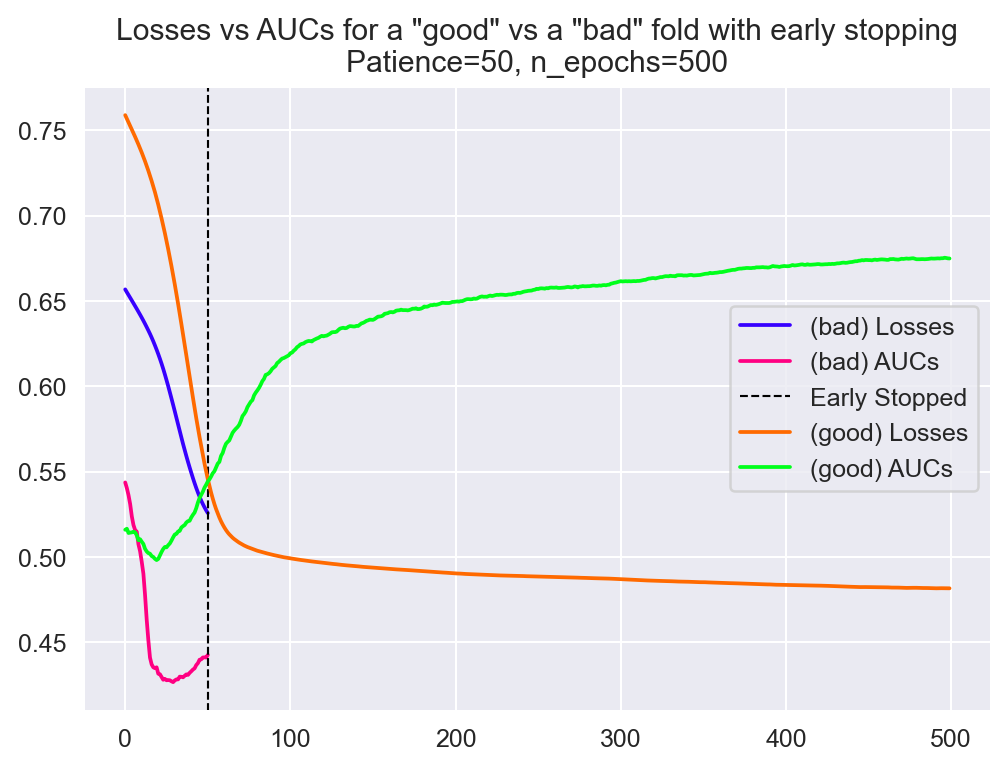

In [151]:
f,a = plt.subplots(1,1, figsize=(6.5,4.5))
a.plot(range(len(ls)), ls, label ='(bad) Losses')
a.plot(range(len(aucs)),aucs, label='(bad) AUCs')
a.set_title('Losses vs AUCs for a "problematic" fold with early stopping\nPatience=50, n_epochs=500')
a.legend()
a.axvline(x=50, label = 'Early Stopped', ls ='--', lw=.85, c='k')
a.plot(range(len(lsgood)), lsgood, label ='(good) Losses')
a.plot(range(len(aucsgood)),aucsgood, label='(good) AUCs')
a.set_title('Losses vs AUCs for a "good" vs a "bad" fold with early stopping\nPatience=50, n_epochs=500')
a.legend()

In [117]:
np.argmax(dump['mean_valid_auc']), np.argmin(dump['mean_valid_losses'])

(341, 228)

In [99]:
dump['mean_valid_auc'][173], dump['mean_valid_auc'][123]

(0.6264440801444802, 0.6255886516024077)

## early stop 

Some folds don't train at all, and seems to just predict "negative" and will get it right 80% of the time (~80% accuracy but <50% AUC)

In [123]:
cedar_related.query('fold!=5 and fold !=0').groupby('agg_label').agg(count=('Peptide','count'))/len(cedar_related.query('fold!=5 and fold !=0'))

,count
agg_label,
0,0.789066
1,0.210934


In [131]:
fup = cedar_related.query('fold!=5 and fold !=9')
fup.groupby('agg_label').agg(count=('Peptide','count'))/len(fup)

,count
agg_label,
0,0.787781
1,0.212219


## other stuff


In [84]:
pkl_dump(dump, '../output/nn_test/metrics_2.pkl')

../output/nn_test/metrics_2.pkl saved.


In [94]:
dump = pkl_load('../output/test/params/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

Text(0.5, 0, 'Epoch')

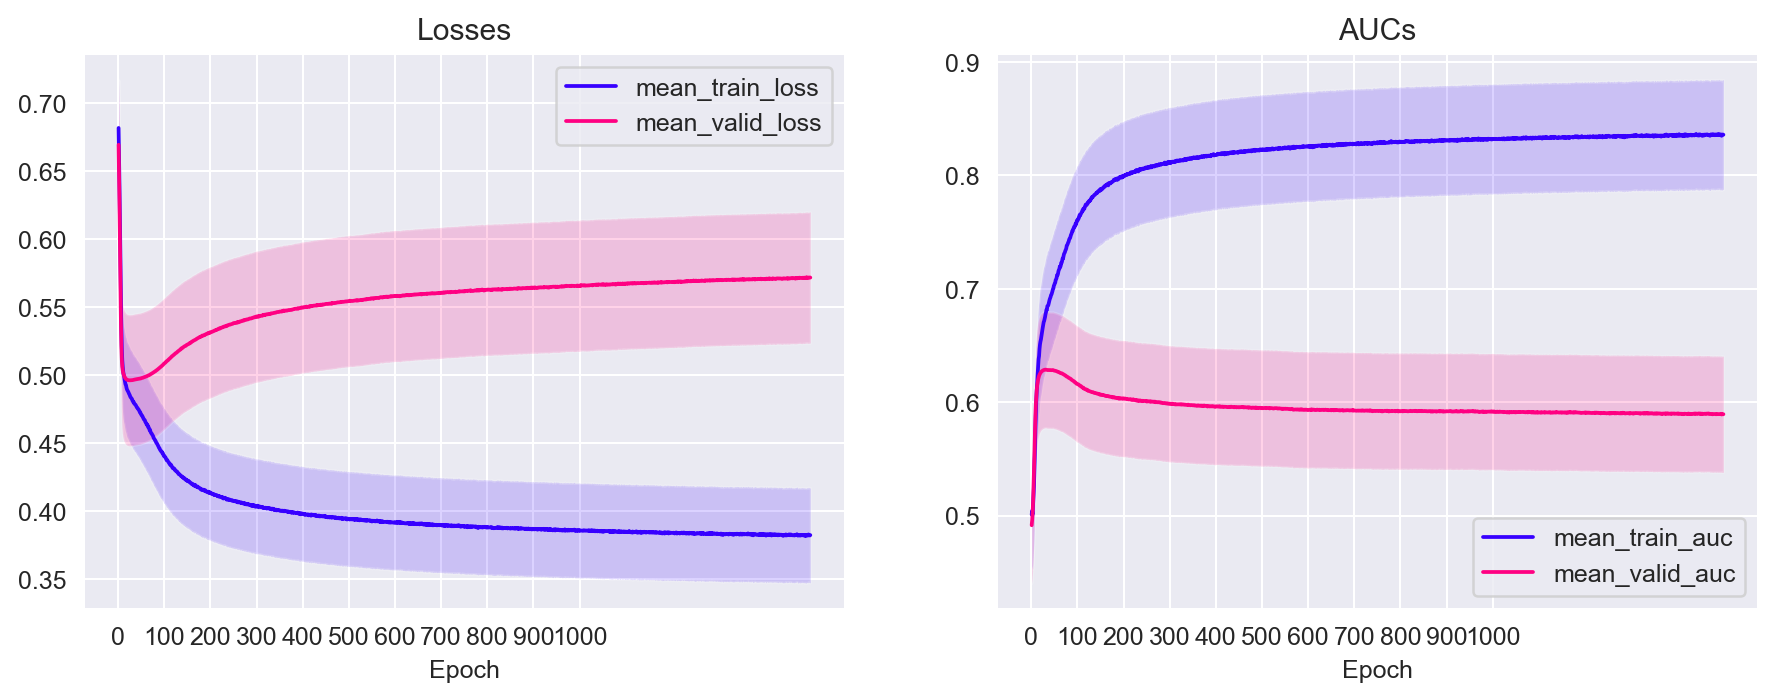

In [95]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1100, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1100, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')


In [157]:
tune_df = pd.read_csv('../output/nn_manual_tune_qsub/manual_tune_results.csv')
tune_df

,lr,n_hidden,n_layers,train_auc,valid_auc,test_auc,external_prime_auc
0,0.00005,10,1,0.731887,0.634764,0.643303,0.552908
1,0.00005,10,2,0.733215,0.633586,0.645128,0.556696
2,0.00005,10,3,0.736259,0.633165,0.648490,0.560990
3,0.00005,25,1,0.797204,0.624861,0.638391,0.551758
4,0.00005,25,2,0.814201,0.609157,0.627764,0.548986
5,0.00005,25,3,0.824851,0.607342,0.633291,0.556426
6,0.00005,40,1,0.843393,0.621670,0.641843,0.556311
7,0.00005,40,2,0.870319,0.604937,0.633229,0.554070
8,0.00005,40,3,0.882426,0.593312,0.630564,0.551482
9,0.00010,10,1,0.764014,0.622562,0.644419,0.558201


In [165]:
print('Valid')
display(tune_df.sort_values('valid_auc', ascending=False).head(3))
print('Test')
display(tune_df.sort_values('test_auc', ascending=False).head(3))
print('ext test')
display(tune_df.sort_values('external_prime_auc', ascending=False).head(3))

Valid


,lr,n_hidden,n_layers,train_auc,valid_auc,test_auc,external_prime_auc
0,0.00005,10,1,0.731887,0.634764,0.643303,0.552908
1,0.00005,10,2,0.733215,0.633586,0.645128,0.556696
2,0.00005,10,3,0.736259,0.633165,0.648490,0.560990


Test


,lr,n_hidden,n_layers,train_auc,valid_auc,test_auc,external_prime_auc
2,0.00005,10,3,0.736259,0.633165,0.648490,0.560990
11,0.00010,10,3,0.775108,0.613975,0.647589,0.562736
1,0.00005,10,2,0.733215,0.633586,0.645128,0.556696


ext test


,lr,n_hidden,n_layers,train_auc,valid_auc,test_auc,external_prime_auc
11,0.00010,10,3,0.775108,0.613975,0.647589,0.562736
15,0.00010,40,1,0.879318,0.610613,0.638381,0.561676
2,0.00005,10,3,0.736259,0.633165,0.648490,0.560990


# debug nans

In [ ]:
x_train = pkl_load('./x_train.pkl')
y_train = pkl_load('./y_train.pkl')
model = pkl_load('./model.pkl')
optim = pkl_load('./optim.pkl')
train_loader = pkl_load('./train_loader.pkl')
criterion = pkl_load('./criterion.pkl')

In [214]:
# --> When masked, standardizer returned nans in the input